In [1]:
import numpy as np
import pandas as pd
import cv2
import glob
import matplotlib.pyplot as plt
import time
from scipy.ndimage.measurements import label
%matplotlib inline

In [2]:
from keras.models import Model, load_model
from keras.layers import Input, Lambda, Conv2D, MaxPooling2D, BatchNormalization, Dense, GlobalAveragePooling2D
from keras.layers import  Flatten, Reshape, Concatenate, Activation, Dropout
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, LambdaCallback
from keras import backend as K
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator


from keras.applications.mobilenet import MobileNet, relu6, DepthwiseConv2D

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
model = load_model('./models/mobilenet_finetune_v2_50epochs.h5', custom_objects={
                   'relu6': relu6,
                   'DepthwiseConv2D': DepthwiseConv2D})

In [10]:
test_imgs_cars = glob.glob('./data_keras/test/cars/*.png')

In [17]:
test_inputs = []

for i in test_imgs_cars[:5]:
    img = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    test_inputs.append(img / 255.)
    
predictions = model.predict(np.array(test_inputs))

In [18]:
predictions

array([[  2.42977633e-28],
       [  8.60438558e-06],
       [  2.73534537e-12],
       [  2.79804021e-02],
       [  9.99778092e-01]], dtype=float32)

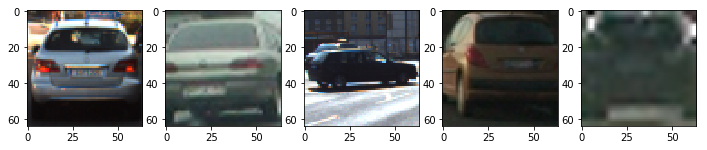

In [16]:
plt.figure(figsize=(12,8))
for i in range(5):
    ax = plt.subplot(1, 5, i+1)
    ax.imshow(cv2.cvtColor(cv2.imread(test_imgs_cars[i]), cv2.COLOR_BGR2RGB))

In [19]:
test_imgs_notcars= glob.glob('./data_keras/test/notcars/*.png')

test_inputs_2 = []

for i in test_imgs_notcars[:5]:
    img = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    test_inputs_2.append(img/255.)
    
predictions2 = model.predict(np.array(test_inputs_2))

In [20]:
predictions2

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.]], dtype=float32)

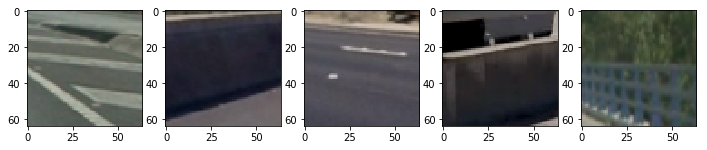

In [21]:
plt.figure(figsize=(12,8))
for i in range(5):
    ax = plt.subplot(1, 5, i+1)
    ax.imshow(cv2.cvtColor(cv2.imread(test_imgs_notcars[i]), cv2.COLOR_BGR2RGB))

### Simple sliding windows

In [6]:
# use a sliding window function to split the image into many small boxes, then use the trianed network to look for cars:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size (ie look at whole image-- more expensive)
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    #x and y ranges for windows
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels the new window will move, so width of window * (1 - overlap)
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for y in range(ny_windows):
        for x in range(nx_windows):
            # Calculate window position
            startx = x * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = y * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), linesize=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, linesize)
    # Return the image copy with boxes drawn
    return imcopy

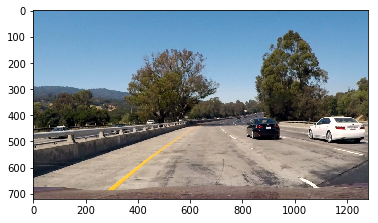

In [9]:
test1 = cv2.cvtColor(cv2.imread('./test_images/test1.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(test1)

In [30]:
windows_small = slide_window(test1, x_start_stop=[None, None], y_start_stop=[300, None], 
                    xy_window=(64, 32), xy_overlap=(0.6, 0.6))
windows_large = slide_window(test1, x_start_stop=[None, None], y_start_stop=[300, None], 
                    xy_window=(150,80), xy_overlap=(0.6, 0.6))

In [31]:
def preprocess_img(imgarr, window):
    test_img = cv2.resize(imgarr[window[0][1]:window[1][1], window[0][0]:window[1][0]], (128,128))
    test_img = test_img/255.
    return test_img
    
prediction_arrary = [preprocess_img(test1, x) for x in windows_small]
prediction_arrary_large = [preprocess_img(test1, x) for x in windows_large]

In [32]:
outputs_small = model.predict(np.array(prediction_arrary))
outputs_large = model.predict(np.array(prediction_arrary_large))

In [33]:
cars_windows_idx = np.nonzero(outputs_small.T[0] <0.1)
cars_windows_idx_large = np.nonzero(outputs_large.T[0] <0.1)

In [34]:
boxes = []
for i in cars_windows_idx[0]:
    boxes.append(windows_small[i])
for i in cars_windows_idx_large[0]:
    boxes.append(windows_large[i])

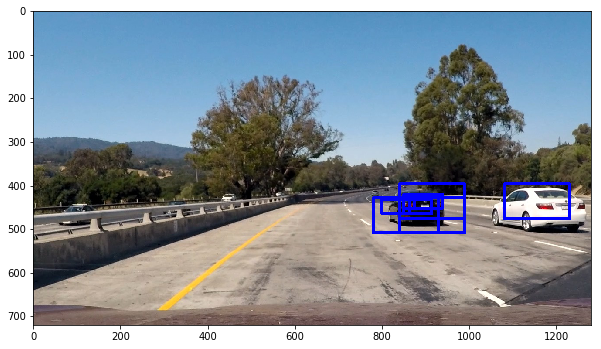

In [35]:
outimg = draw_boxes(np.copy(test1), boxes)
plt.figure(figsize=(10,7))
plt.imshow(outimg)

In [45]:
# generate different window sizes
def define_multiscale_window(img):
    y_start_stop = [int(0.5 * img.shape[0]), img.shape[0] -50]
    y_start_stop_small = [int(0.5 * img.shape[0]), int(0.7 * img.shape[0])]
    y_start_stop_med = [int(0.5 * img.shape[0]), int(0.8 * img.shape[0])]
    windowsizes = [32,64,128, 256]
    
    windows_small = slide_window(img, y_start_stop=y_start_stop_small, 
                    xy_window=(32, 24), xy_overlap=(0.6, 0.6))
    windows_small2 =  slide_window(img, y_start_stop=y_start_stop_med, 
                    xy_window=(64, 32), xy_overlap=(0.6, 0.6))
    windows_large1  =  slide_window(img, y_start_stop=y_start_stop, 
                    xy_window=(128,90), xy_overlap=(0.6, 0.6))
#     windows_large2 =  slide_window(img, y_start_stop=y_start_stop, 
#                     xy_window=(200,200))
    return windows_small + windows_small2 + windows_large1 #+ windows_large2

In [52]:
def get_hot_boxes(img, windows, model):
    imgs = []
    prediction_arrary = [preprocess_img(img, x) for x in windows]
    outputs = model.predict(np.array(prediction_arrary))
    cars_windows_idx = np.nonzero(outputs.T[0] <0.3)
    boxes = []
    for i in cars_windows_idx[0]:
        boxes.append(windows[i])
    return boxes

In [53]:
multiwindows = define_multiscale_window(test1)
                                        
outimg2 = get_hot_boxes(test1, multiwindows, model)

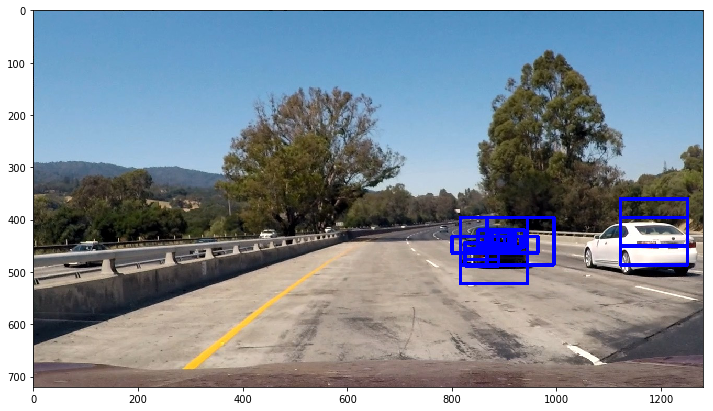

In [55]:
plt.figure(figsize=(12,8))
plt.imshow(draw_boxes(np.copy(test1), outimg2))

time taken for 6 images: 28.53180694580078


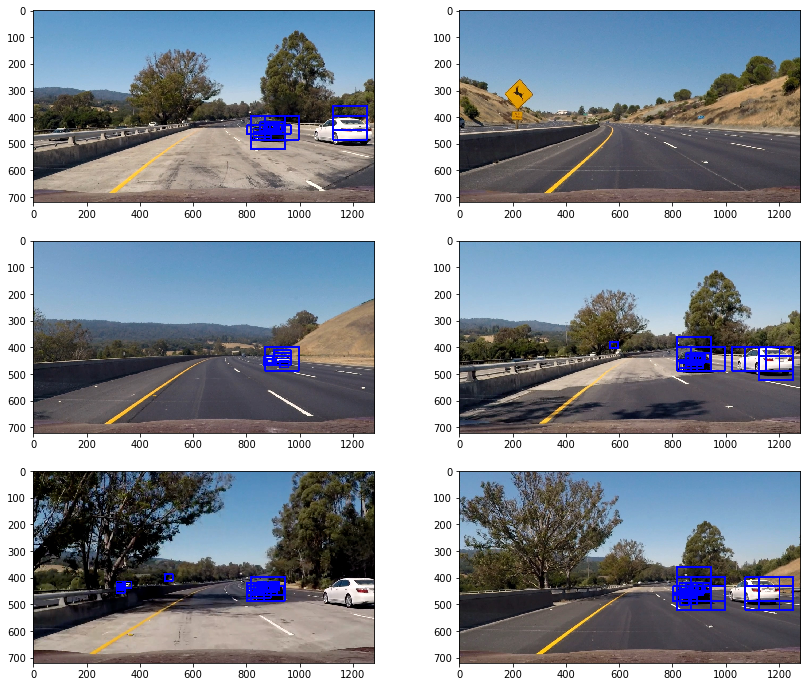

In [56]:
plt.figure(figsize=(14,12))
multiwindows = define_multiscale_window(test1)
start = time.time()
for i in range(6):
    img = cv2.cvtColor(cv2.imread('./test_images/test'+ str(i+1) +'.jpg') ,cv2.COLOR_BGR2RGB) 
    outimg =get_hot_boxes(img, multiwindows, model)
    ax = plt.subplot(3,2, i + 1)
    ax.imshow(draw_boxes(img, outimg))
end = time.time()
print('time taken for 6 images:', (end -start))

In [57]:
def construct_heatmap(image, bounding_boxes, threshold = 0):
    heatmap = np.zeros_like(image[:,:,0])
    # Iterate through list of bboxes
    for box in bounding_boxes:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
    
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

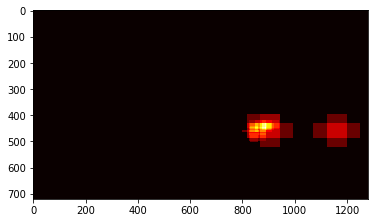

In [58]:
heatmap = construct_heatmap(test1, outimg, 1)
plt.imshow(np.clip(heatmap, 0, 255), cmap='hot')

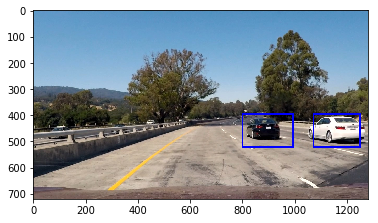

In [59]:
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test1), labels)

plt.figure()
plt.imshow(draw_img)


In [60]:
from moviepy.editor import VideoFileClip

In [61]:
def pipeline(img): 
    multiwindows = define_multiscale_window(img)
    hotboxes =get_hot_boxes(img, multiwindows, model)
    heatmap = construct_heatmap(img, hotboxes, 1)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img


In [62]:
input_video = 'project_video.mp4'
output_video = 'outvideo_mobilenet_full.mp4'
clip1 = VideoFileClip(input_video)#.subclip(20,40)
clipout = clip1.fl_image(pipeline)
%time clipout.write_videofile(output_video, audio=False, progress_bar=False)

[MoviePy] >>>> Building video outvideo_mobilenet_full.mp4
[MoviePy] Writing video outvideo_mobilenet_full.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: outvideo_mobilenet_full.mp4 

CPU times: user 1h 13min 41s, sys: 32min 36s, total: 1h 46min 17s
Wall time: 1h 38min 42s
